In [ ]:
Original Google Colab link : https://colab.research.google.com/drive/1WIDhjHemJ8VCzd2C7iQjcNo8w_yi3ayz?usp=sharing

**Data Mining - Topic Extraction from StackOverflow Data in the Context of Software Architecture.**

# Import statements

In [ ]:
!pip install stackapi
!pip install s3fs
!pip install pandas
!pip install numpy
!pip install nltk
!pip install sklearn
!pip install keras
!pip install regex
!pip install matplotlib
!pip install bs4 lxml

  Created wheel for stackapi: filename=StackAPI-0.1.12-cp36-none-any.whl size=5667 sha256=83796dfdfe1ff2978a644849deb2cc8bbd25a06de8bb520a363967c82d0d766d
  Stored in directory: /root/.cache/pip/wheels/16/bf/a5/56362daf788c5ce88244796b26d3e7d6fec649f5e77aff694c
Successfully built stackapi


In [ ]:
!pip install lda
!pip install tensorflow

     |████████████████████████████████| 358kB 3.2MB/s 
     |████████████████████████████████| 102kB 8.6MB/s 


In [ ]:
import pandas as pd     
import numpy as np
import s3fs
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords 
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

import regex as re

import matplotlib.pyplot as plt

from keras.preprocessing.text import Tokenizer 

from stackapi import StackAPI

import seaborn as sns
sns.set(style="whitegrid")

from scipy import stats

import lda

from bokeh.palettes import Set3, Blues8, brewer

from sklearn.feature_extraction.text import CountVectorizer

import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

# Data Extraction using StackAPI

In [ ]:
#key is required for extracting more than 500 posts from the stackoverflow api.
#maximum posts retrieved using this query will be max_pages * page_size = 100,000
SITE = StackAPI('stackoverflow', max_pages=1000, page_size=100, key='kGCevKwTYZ)K3MXyECOpmg((')

#basically we are collecting ten years worth of data
#1262304000 date refers to 01-01-2010
questions = SITE.fetch('posts', tagged='software-design', filter='withbody', fromdate=1262304000)

In [ ]:
#store the indexed content of the posts along with the score
import csv
stackoverflow_data = []
i =  1
for item in questions['items']:
  stackoverflow_data.append({'id': i, 'contents': item['body'], 'score':item['score']})
  i = i + 1
 
csv_file = "stackoverflow_data.csv"
with open(csv_file, 'w') as csvfile:
  writer = csv.DictWriter(csvfile, fieldnames=['id','contents','score'])
  writer.writeheader()
  for data in stackoverflow_data:
    writer.writerow(data)

In [ ]:
#Verify that stackoverflow data is accessible
# !pip install google-colab
import os
from google.colab import drive
drive.mount('/content/drive/')
!ls "/content/drive/My Drive/stackoverflow_data"

In [ ]:
# READ DATASET INTO DATAFRAME

df = pd.read_csv("/content/drive/My Drive/stackoverflow_data.csv")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# Sampling the dataset
df  = df.sample(n=25000, random_state=1)

In [ ]:
df.head

<bound method NDFrame.head of           id                                           contents  score
43660  43661  <p>I would just use window functions:</p>\n<pr...      0
87278  87279  <p>I am trying to create a Shiny app that will...      0
14317  14318  <p>setState is async. React events are pooled ...      0
81932  81933  <p>And for the fun the bash version !</p>\n<pr...      4
95321  95322  <p>You can use provider instead of creating gl...      0
...      ...                                                ...    ...
54026  54027  <p>An option is to <code>split</code> the data...      1
79431  79432  <p>I have this piece of code written by somebo...      3
2227    2228  <p>My if else statement not working.. No matte...     -1
43025  43026  <p>Here is the code which covers the case of v...      1
67164  67165  <p>I'm actually in the process of refactoring ...      0

[25000 rows x 3 columns]>

# Dataset view

In [ ]:
# SHAPE of DATAFRAME

df.shape

(25000, 3)

In [ ]:
# VIEW OF A DATAFRAME

df.head(5)

,id,contents,score
43660,43661,<p>I would just use window functions:</p>\n<pr...,0
87278,87279,<p>I am trying to create a Shiny app that will...,0
14317,14318,<p>setState is async. React events are pooled ...,0
81932,81933,<p>And for the fun the bash version !</p>\n<pr...,4
95321,95322,<p>You can use provider instead of creating gl...,0


In [ ]:
# VIEW OF A RAW contents

df.iloc[0, 1]

"<p>I would just use window functions:</p>\n<pre><code>select t.*\nfrom (select t.*\n             row_number() over (partition by id order by time desc) as seqnum,\n             sum(case when status = 'T' then 1 else 0 end) over (partition by id) as num_t\n      from t\n     ) t\nwhere num_t &gt; 0 and\n      seqnum = 1 and status = 'F';\n</code></pre>\n<p>There is a another fun way to do this just with aggregation:</p>\n<pre><code>select id, max(time) as time, 'F' as status\nfrom t\ngroup by id\nhaving sum(case when status = 'T' then 1 else 0 end) &gt; 0 and\n       max(time) = max(case when status 'F' then time end);\n</code></pre>\n"

## Upvote-Score Analysis

In [ ]:
(df["score"].describe())

count    25000.000000
mean         4.413280
std         53.354105
min         -9.000000
25%          0.000000
50%          0.000000
75%          1.000000
max       3685.000000
Name: score, dtype: float64

# Data Preprocessing 

### Remove code from Contents column

In [ ]:
#Remove all the code details from the posts
from bs4 import BeautifulSoup as bs
import lxml

new_data = []
for post in df['contents']:
  data = bs(post, 'lxml')
  for tag in data.find_all('code'):
    tag.decompose()
  new_data.append(data)
df['contents']  = [ str(item) for item in new_data]

In [ ]:
# DROP ROWS WHICH HAS SAME contents
df.drop_duplicates(subset=['contents'],inplace=True)  #dropping duplicates
# DROP ROWS WITH NA VALUES
df.dropna(axis=0,inplace=True)

In [ ]:
# NEW/CURRENT SHAPE of DATAFRAME

df.shape

(24600, 3)

In [ ]:
# ALTHOUGH IT SEEMS THAT WE DON'T HAVE ANY CONTRACTIONS BUT IT IS A GOOD PRACTICE TO CHECK IF THEY EXIST AND REMOVE IF THEY ARE THERE.

df[df['contents'].str.match('\'')]

,id,contents,score


### Remove URLs


In [ ]:
# Identify records with URL and Drop records with URL in summary
# https://www.geeksforgeeks.org/python-check-url-string/

def remove_urls(df):
  """
  This method removes the records containing URLs in the contents section
  """
    
  url_regex = r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))"

  print("Total records:", len(df))

  df['hasURL'] = df['contents'].apply(lambda contents : bool(len([x[0] for x in re.findall(url_regex, contents)])))
  df = df[df['hasURL']==False]
  df.drop(columns=['hasURL'], inplace=True)           # dropping the 'hasURL' column
  return df


In [ ]:
df = remove_urls(df)

Total records: 24600


In [ ]:
df.shape

(16794, 3)

### Lower-case conversion, Remove HTML tags and stop-words

In [ ]:
stop_words = set(stopwords.words('english'))              # Prepare a set of STOPWORDS

def summary_cleaner(text):

  newString = text.lower()                                # CONVERT INTO LOWER CASE
  newString = re.sub(re.compile('<.*?>'), " ", newString) # REMOVE HTML TAGS
  newString = re.sub(r'\([^)]*\)', '', newString)         # REMOVE SMALL BRACKETS i.e "(xxxx)" => xxxx
  newString = re.sub('"','', newString)                   # REMOVE INVERTED COMMA'S
  newString = re.sub(r"'s\b","",newString)                # REMOVE 's FROM THE LAST OF ANY TOKEN
  newString = re.sub("[^a-zA-Z]", " ", newString)         # REMOVE NUMERIC content.

  tokens = [w for w in newString.split() if not w in stop_words]    # REMOVE STOP WORDS
  return (" ".join(tokens)).strip()

cleaned_summary = []
for text in df['contents']:
  cleaned_summary.append(summary_cleaner(text))


In [ ]:
# VIEW OF A CLEAN SUMMARY

cleaned_summary[0]

'would use window functions another fun way aggregation'

In [ ]:
len(cleaned_summary)

16794

In [ ]:
# VIEW OF RAW Contents

df.iloc[0, 1]

'<html><body><p>I would just use window functions:</p>\n<pre></pre>\n<p>There is a another fun way to do this just with aggregation:</p>\n<pre></pre>\n</body></html>'

In [ ]:
# # ADD the CLEANED SUMMARY AND HEADLINE INTO DATAFRAME IN NEW COLUMNS

df['cleaned_contents']= cleaned_summary


### Cleaned Dataset view

In [ ]:
pd.set_option('display.width', 1000)
df.iloc[0:5, 3]

43660    would use window functions another fun way agg...
81932                                     fun bash version
5405                                                      
33188                      simply remove valid archs works
63421    might work replace first two characters first ...
Name: cleaned_contents, dtype: object

In [ ]:
writer = pd.ExcelWriter('Cleaned_Data.xlsx')
df.to_excel(writer)
writer.save()

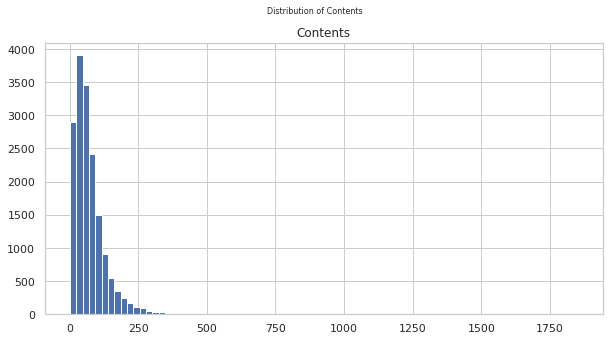

In [ ]:
# populate the lists with sentence lengths
summary_word_count = [len(i.split()) for i in df['contents']]

length_df = pd.DataFrame({'Contents':summary_word_count})
length_df.hist(bins=80, figsize=(10,5) )
plt.suptitle("Distribution of Contents", size=8)
plt.show()

#### Effective Lemmatization - Tokenization, POS Tagging, POS Tagging - Wordnet, Lemmatization 

In [ ]:
# Word Tokenization of Sequences
def tokenize_dataset(data):
  """
  This method is used to convert input data sequence into tokenized word sequences.
  """
  return([nltk.word_tokenize(samples) for samples in data])

# POS Tagging of Tokens
def pos_tagging_tokens(data):
  return([nltk.pos_tag(samples) for samples in data])

In [ ]:
# X Values
# Calling Tokenization method on Data sequences
tokens_X_train = tokenize_dataset(df["cleaned_contents"])

# Calling POS tagging method on Tokenized sequences
tagged_tokens_X_train = pos_tagging_tokens(tokens_X_train)

In [ ]:
print(tokens_X_train[10])


['working', 'twilio', 'programmable', 'video', 'hit', 'snag', 'issue', 'programmable', 'video', 'moment', 'requires', 'users', 'manually', 'enter', 'roomid', 'name', 'like', 'send', 'user', 'url', 'name', 'roomid', 'already', 'baked', 'instantly', 'click', 'join', 'possible', 'know', 'hit', 'endpoint', 'returns', 'token', 'unsure', 'leverage', 'dynamically', 'enter', 'room', 'without', 'user', 'still', 'manually', 'enter', 'information', 'help', 'would', 'appreciated']


In [ ]:
print(tagged_tokens_X_train[1])

[('fun', 'NN'), ('bash', 'NN'), ('version', 'NN')]


#### Converting POS Tags to WordNet Tags

In [ ]:
wnl = WordNetLemmatizer()

def pos_tag_wordnet(data):
  """
    This method converts POS tags of input sequences to Effective Lemmatizaton tags sequences.
  """
  new_tagged_tokens = []
  tag_map = {'j': wordnet.ADJ, 'v': wordnet.VERB, 'n': wordnet.NOUN, 'r': wordnet.ADV}
  for tagged_tokens in data:
    new_tagged_tokens.append([(word, tag_map.get(tag[0].lower(), wordnet.NOUN)) for word, tag in tagged_tokens])
  return new_tagged_tokens

In [ ]:
# X Values
new_tagged_tokens_X_train = pos_tag_wordnet(tagged_tokens_X_train)

In [ ]:
len(new_tagged_tokens_X_train)

16794

In [ ]:
# Create lemmatization 
def lemmatized_text(wordnet_tokens_data):
  """
  This method converts input tokenized sequence into lemmatized text sequence.
  """
  return([ ' '.join(wnl.lemmatize(word, tag) for word, tag in wordnet_tokens) for wordnet_tokens in wordnet_tokens_data])

In [ ]:
# X Values
lemmatized_text_X_train = lemmatized_text(new_tagged_tokens_X_train)

In [ ]:
print(lemmatized_text_X_train[0])

would use window function another fun way aggregation


In [ ]:
X_tokenizer = Tokenizer()
X_tokenizer.fit_on_texts(list(lemmatized_text_X_train))

In [ ]:
 # Summary vocab size

X_vocabulary_size   =  len(X_tokenizer.word_index) +1

print("Size of Vocabulary for Cleaned Contents:", X_vocabulary_size)

Size of Vocabulary for Cleaned Contents: 22076


# Performing LDA - Topic Modelling

## Converting data into Term-Frequency Matrix (tf, unigrams)


In [ ]:
cv = CountVectorizer(min_df=0., max_df=1.)
cv_matrix = cv.fit_transform(lemmatized_text_X_train)
cv_matrix = cv_matrix.toarray()
cv_matrix

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:

# get all unique words in the corpus
vocab = cv.get_feature_names()
# show document feature vectors
pd.DataFrame(cv_matrix, columns=vocab)

,aa,aaa,aaaa,aaaaaa,aaaabbbbccccdddd,aaas,aab,aabb,aac,aad,aadityadengle,aadsts,aakarsh,aapl,aapp,aar,aarguments,aaron,aassociated,aatext,ab,aba,ababa,abac,abandon,abap,abbinsankaynaklari,abble,abbot,abbreviate,abbreviated,abbreviation,abc,abcand,abcbcd,abcc,abcd,abcdefg,abd,abdroid,...,zfsonlinux,zgl,zi,zindex,zip,zipalign,zipcode,zipfile,zipinputstream,zipp,zipper,zk,zlib,zlxnlcmlmo,zmq,zolt,zombie,zone,zonename,zookeeper,zookeepers,zooliz,zoom,zorder,zot,zsh,zshrc,ztm,ztoxljdlbtttyxjnaw,ztoyljrlbtttyxjnaw,ztt,zuul,zvbnqtc,zvbnqtzmftawx,zvika,zw,zxing,zxx,zyx,zzzzzzzzz
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16789,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
16790,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
16791,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
16792,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Train the Model

In [ ]:
model = lda.LDA(n_topics=30, n_iter=20000, random_state=100)
# cause and effect relationship, Conclusion Validity , End output changes by changing these params

In [ ]:
X = cv_matrix

In [ ]:
model.fit(X)

INFO:lda:n_documents: 16794
INFO:lda:vocab_size: 22052
INFO:lda:n_words: 560080
INFO:lda:n_topics: 30
INFO:lda:n_iter: 20000
INFO:lda:<0> log likelihood: -6900361
INFO:lda:<10> log likelihood: -4941107
INFO:lda:<20> log likelihood: -4730511
INFO:lda:<30> log likelihood: -4636848
INFO:lda:<40> log likelihood: -4579168
INFO:lda:<50> log likelihood: -4541820
INFO:lda:<60> log likelihood: -4514712
INFO:lda:<70> log likelihood: -4495846
INFO:lda:<80> log likelihood: -4482893
INFO:lda:<90> log likelihood: -4472141
INFO:lda:<100> log likelihood: -4466189
INFO:lda:<110> log likelihood: -4457071
INFO:lda:<120> log likelihood: -4451215
INFO:lda:<130> log likelihood: -4446187
INFO:lda:<140> log likelihood: -4441802
INFO:lda:<150> log likelihood: -4438536
INFO:lda:<160> log likelihood: -4434027
INFO:lda:<170> log likelihood: -4433614
INFO:lda:<180> log likelihood: -4428567
INFO:lda:<190> log likelihood: -4425059
INFO:lda:<200> log likelihood: -4423032
INFO:lda:<210> log likelihood: -4421882
INFO:l

In [ ]:
topic_word = None
topic_word = model.topic_word_

# Results

##Extracting "K" topics

In [ ]:
import joblib

joblib.dump(model, '/content/drive/My Drive/lda_model.jl')


['/content/drive/My Drive/lda_model.jl']

In [ ]:
# Reload the model object
import joblib
reload_model = joblib.load('/content/drive/My Drive/lda_model.jl')
doc_topic = None
topic_word= None
doc_topic = reload_model.doc_topic_
topic_word = reload_model.topic_word_

In [ ]:
n_top_words = 100
for i, topic_dist in enumerate(topic_word):
  topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
  print('Topic {}: {}'.format(i, ' '.join(topic_words)))

Topic 0: run test command script use work docker build file container try execute environment log start set server task job fine get pipeline deploy service output variable want terminal window agent local write different step result application follow production create jenkins ssh shell machine also fail issue change case powershell setup console config default bash locally project process app image configuration add via line compose stage idea heroku system way launch inside go see without dockerfile env host currently however directly exe release everything yml action dev like azure root development able take schedule directory ansible time configure linux specify git
Topic 1: would need one make like way use could case thing think good well solution see look might know go also even different option say question answer may something since actually two best approach take time seem let much instead point easy really lot still sure end simple example bit first start probably however ri

## Document-topic distributions/ Percentage share

In [ ]:
for i in range(20):
  print("Stackoverflow Question index: {} (top topic: {})".format(df.iloc[i,0], doc_topic[i].argmax()))

Stackoverflow Question index: 43661 (top topic: 6)
Stackoverflow Question index: 81933 (top topic: 9)
Stackoverflow Question index: 5406 (top topic: 0)
Stackoverflow Question index: 33189 (top topic: 2)
Stackoverflow Question index: 63422 (top topic: 10)
Stackoverflow Question index: 72898 (top topic: 5)
Stackoverflow Question index: 9508 (top topic: 10)
Stackoverflow Question index: 88625 (top topic: 28)
Stackoverflow Question index: 99244 (top topic: 15)
Stackoverflow Question index: 31792 (top topic: 22)
Stackoverflow Question index: 45418 (top topic: 8)
Stackoverflow Question index: 91217 (top topic: 12)
Stackoverflow Question index: 31925 (top topic: 12)
Stackoverflow Question index: 15135 (top topic: 24)
Stackoverflow Question index: 16406 (top topic: 18)
Stackoverflow Question index: 22719 (top topic: 17)
Stackoverflow Question index: 15523 (top topic: 20)
Stackoverflow Question index: 24508 (top topic: 7)
Stackoverflow Question index: 13980 (top topic: 1)
Stackoverflow Question

In [ ]:
df

,id,contents,score,cleaned_contents
43660,43661,<html><body><p>I would just use window functio...,0,would use window functions another fun way agg...
81932,81933,<html><body><p>And for the fun the bash versio...,4,fun bash version
5405,5406,<html><body><pre></pre>\n</body></html>,2,
33188,33189,<html><body><p>You can simply remove VALID_ARC...,0,simply remove valid archs works
63421,63422,<html><body><p>This might work for you (GNU se...,0,might work replace first two characters first ...
...,...,...,...,...
66181,66182,"<html><body><p>Okay, I have a script like this...",0,okay script like start script usual way immedi...
72089,72090,<html><body><p>Interpolate function works with...,0,interpolate function works input output know i...
54026,54027,<html><body><p>An option is to the dataset an...,1,option dataset use data
43025,43026,<html><body><p>Here is the code which covers t...,1,code covers case variable number second row va...


In [ ]:
df["topic_number"] = list(map(lambda x: x.argmax(), doc_topic))

In [ ]:
data = df["topic_number"].value_counts().sort_index()
data

0     665
1     907
2     605
3     626
4     488
5     754
6     680
7     121
8     509
9     460
10    740
11    328
12    398
13    446
14    838
15    795
16    411
17    338
18    612
19    525
20    652
21    583
22    650
23    391
24    440
25    599
26    402
27    624
28    660
29    547
Name: topic_number, dtype: int64

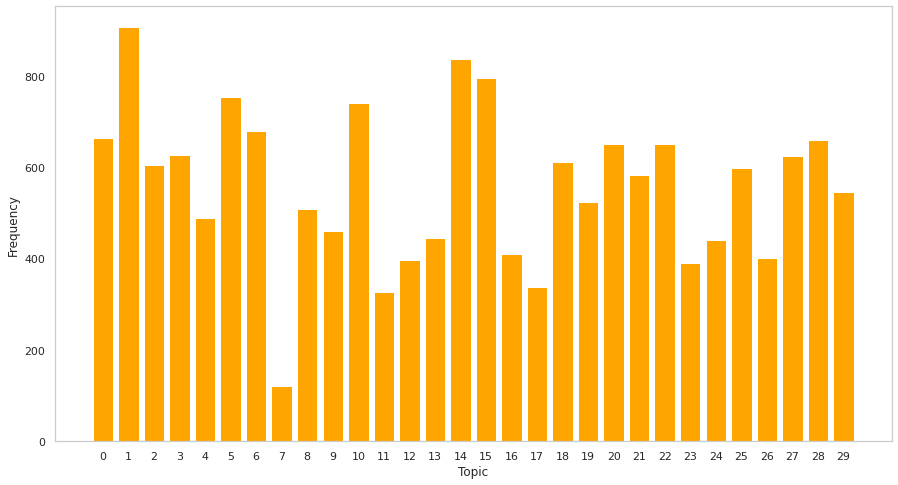

In [ ]:
plt.figure(figsize = (15, 8))
plt.bar(np.arange(data.shape[0]), data, color = 'orange')
plt.xticks(np.arange(data.shape[0]))
plt.grid(False)
plt.xlabel("Topic")
plt.ylabel("Frequency")
plt.savefig("topic.pdf")

In [ ]:
data_np = data.to_numpy()
sorted_data = data.sort_values(ascending=False)
sorted_data.values

array([907, 838, 795, 754, 740, 680, 665, 660, 652, 650, 626, 624, 612,
       605, 599, 583, 547, 525, 509, 488, 460, 446, 440, 411, 402, 398,
       391, 338, 328, 121])

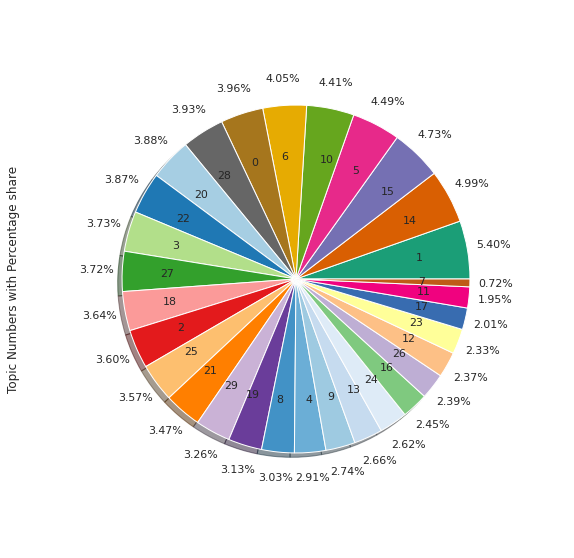

In [ ]:
sorted_data.plot.pie(y='mass', figsize=(10, 10), autopct= '%1.2f%%', pctdistance=1.15, 
                     labeldistance=0.7, radius= 0.8, shadow=True,  fontsize=11, 
                     colors = brewer['Dark2'][8] +brewer["Paired"][10]+ Blues8[2:7]+brewer["Accent"][8])
plt.ylabel("Topic Numbers with Percentage share")
plt.savefig("pie_chart.png")